In [ ]:
!pip install cohere

In [ ]:
!pip install langchain

In [ ]:
!pip install faiss-cpu

In [5]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter,TextSplitter
from langchain import OpenAI, VectorDBQA
from langchain.document_loaders import DirectoryLoader
from langchain.agents import initialize_agent, Tool
#import magic
import os
import nltk
from langchain.prompts.prompt import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import ReadTheDocsLoader
from langchain.vectorstores.faiss import FAISS
from langchain.embeddings import OpenAIEmbeddings
import pickle
from langchain.chains import ConversationChain
from langchain.llms import OpenAI,Cohere
from langchain.vectorstores.faiss import FAISS
from langchain.embeddings import OpenAIEmbeddings,CohereEmbeddings
from langchain.chains import ChatVectorDBChain
import pickle
from langchain import OpenAI, VectorDBQA
from langchain.prompts.prompt import PromptTemplate



In [6]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def GasInflow(pr, J, GasPVT, n=10):
    # Calculate PseudoPressure
    GasPVT['Ps'] = 2 * GasPVT['P'] / (GasPVT['Mug'] * GasPVT['Z'])

    # Integral Matrix
    Integral = pd.DataFrame()

    # Transfer Pressure to Integrate Matrix
    Integral['P'] = GasPVT['P'][1:]

    # Pressure Differences
    Integral['DiffP'] = np.diff(GasPVT['P'])

    # PseudoPressure Average
    Integral['AvgPs'] = 0.0
    for i in range(len(GasPVT) - 1):
        Integral.loc[i, 'AvgPs'] = (GasPVT.loc[i + 1, 'Ps'] + GasPVT.loc[i, 'Ps']) / 2

    # Cumulative sum
    Integral['Cum'] = Integral['DiffP'] * Integral['AvgPs']
    Integral['Cum'] = Integral['Cum'].cumsum()

    # Interpolation Integral
    mp = interp1d(Integral['P'], Integral['Cum'])

    # IPR Estimation
    pres = np.zeros((n, len(pr)))
    Qg = np.zeros((n, len(pr) * len(J)))
    leg = [None] * (len(pr) * len(J))
    count = 0
    for p in range(len(pr)):
        pres[:, p] = np.linspace(14.7, pr[p] - 50, n)

        for j in range(len(J)):
            count += 1
            leg[count - 1] = f"Res. Pressure={pr[p]} psi; J={J[j]} Mscf/d*psi*cp"
            Qg[:, count - 1] = [J[j] * (mp(pr[p]) - mp(pwf)) for pwf in pres[:, p]]

    return pres, Qg, leg


In [7]:
import numpy as np

def oil_inflow(pr, J, pb=0, n=10):
    pr = np.array(pr, dtype=float)
    J = np.array(J, dtype=float)
    pb = np.array(pb, dtype=float)

    pres = np.zeros((n, len(pr)))
    qrate = np.zeros((n, len(pr) * len(J)))
    sat = pr <= pb

    leg = [None] * (len(pr) * len(J))
    count = 0

    for p in range(len(pr)):
        pres[:, p] = np.linspace(0, pr[p] - 50, n)

        for j in range(len(J)):
            count += 1
            leg[count - 1] = f"Res. Pressure={pr[p]} psi; J={J[j]} bbl/d*psi"

            if sat[p]:
                qrate[:, count - 1] = [(pr[p] * J[j] / 1.8) * (1 - 0.2 * (pwf / pr[p]) - 0.8 * (pwf / pr[p]) ** 2) for pwf in pres[:, p]]
            else:
                qrate[:, count - 1] = [J[j] * (pr[p] - pwf) if pwf >= pb else (J[j] * (pr[p] - pb)) + (J[j] * pb / 1.8) * (1 - 0.2 * (pwf / pb) - 0.8 * (pwf / pb) ** 2) for pwf in pres[:, p]]

    return pres, qrate, leg



In [8]:
import matplotlib.pyplot as plt
#from some_module import OilInflow, GasInflow

def iproil_plot(string):
    #Pr, J,Pb = string.split(",")
    split_list = string.split(',')
    
    result = [float(item) for item in split_list]
    Pr=result[0:1]
    J= result[1:2]
    Pb= result[2:3]
    N=15
    p, q, l = oil_inflow(Pr, J, pb=Pb, n=N)

    plt.plot(q, p, color='black', linewidth=3)
    plt.xlabel("Rate [bbl/d]")
    plt.ylabel("Pwf [psi]")
    plt.title('IPR Plot')
    plt.legend([l])
    plt.show()

In [19]:
def calculate_pressure(input_str):
    # split the input string into depth and mud weight values
    depth, mud_weight = input_str.split(',')
    
    # convert depth and mud weight to floats
    depth = float(depth)
    mud_weight = float(mud_weight)
    
    # calculate pressure using the formula: pressure = 0.016 * depth * mud_weight
    pressure = 0.1706 * depth * mud_weight
    
    # return the pressure value
    return int(pressure)


In [20]:
llm=Cohere(model="command-xlarge-nightly", cohere_api_key="vGCEakgncpouo9Nz0rsJ0Bq7XRvwNgTCZMKSohlg",temperature=0)
tools = [
    Tool(
        name = "IPR Plotter",
        func=iproil_plot,
        description="useful for when you need to plot IPR curve. The input to this tool should be a comma separated list of numbers of length three, representing the three numbers you want to give input to function.\nFor example, 2200,1.5,750 would be the input if you wanted to plot reservoir pressure Pr is 2200,J is 1.5,Pb is 750 .",
        return_direct=True 
    ),
    Tool(
        name = "Pressure Calculator",
        func=calculate_pressure,
        description="useful for when you need to calculate pressures from mud density. The input to this tool should be a comma separated list of numbers of length two, representing the two numbers you want to give input to function.\nFor example 2100,8.6 would be the input if you wanted to calculate pressure where Depth is 2100 and Mud_weight  is 8.6 .",
        return_direct=True 
    )
]

In [21]:

agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)



> Entering new AgentExecutor chain...
 I should use the IPR Plotter
Action: IPR Plotter
Action Input: 2300,2.5,700

<ipython-input-6-43f5cd5d3f2a>:25: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  qrate[:, count - 1] = [J[j] * (pr[p] - pwf) if pwf >= pb else (J[j] * (pr[p] - pb)) + (J[j] * pb / 1.8) * (1 - 0.2 * (pwf / pb) - 0.8 * (pwf / pb) ** 2) for pwf in pres[:, p]]


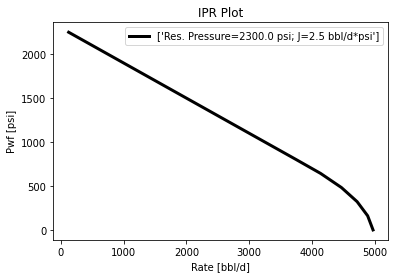


Observation: None


> Finished chain.


In [21]:
agent.run("IPR plot if Pr is 2300,J is 2.5,Pb is 700")

In [22]:
agent.run("Calculate pressure at depth 2000 and mud_weight is 9")



> Entering new AgentExecutor chain...
 I should use the Pressure Calculator
Action: Pressure Calculator
Action Input: 2000,9
Observation: 3070


> Finished chain.


3070